# Import Packages and Dataset

## Packages

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
from keras.engine.topology import Layer
from keras.engine import InputSpec
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints

def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

Using TensorFlow backend.


In [0]:
import numpy as np
import pandas as pd
import json
import re
import sys
from collections import Counter, OrderedDict

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Input,Activation
from keras.layers import SpatialDropout1D
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.constraints import maxnorm
from keras.models import model_from_json
from keras.optimizers import Adam
from keras import regularizers


from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,hamming_loss
from sklearn.preprocessing import MultiLabelBinarizer

from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Dataset

In [0]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
train_path = '/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Data/data_train_nostemstop_preprocessed.csv'

data_train = pd.read_csv(train_path,sep=";")

In [0]:
data_train.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,- kdg will be kind enough to show you how to l...,0,1,0,0,0,0,0,0,0,0,0,0,kadang will be kind enough to show you how to...
1,Ternyata komunis juga bisa nangis',0,0,0,0,0,0,0,0,0,0,0,0,ternyata komunis juga bisa menangis
2,USER USER Kenapa harus bom ya? Kek yg benar nu...,0,0,0,0,0,0,0,0,0,0,0,0,user user kenapa harus bom seperti benar men...
3,USER Sumpaaah kaya kalo abis IAA dilanjut olim...,0,0,0,0,0,0,0,0,0,0,0,0,user sumpah kaya kalau habis iya dilanjut olim...
4,RT USER USER USER USER USER fungsi media sosia...,1,0,1,0,0,0,0,0,1,1,0,0,rt user user user user user fungsi media sosia...


In [0]:
test_path = '/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Data/data_test_nostemstop_preprocessed.csv'

data_test = pd.read_csv(test_path,sep=";")

In [0]:
data_test.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,GANTENG TAPI BERENGSEK!!! BUAT APA?!!\nWHO DO ...,1,1,1,0,0,0,0,0,1,1,0,0,ganteng tapi berengsek buat apa who do you thi...
1,Sakit jiwa kali yah..,0,0,0,0,0,0,0,0,0,0,0,0,sakit jiwa kali
2,"Does insulting one for being ""Cina"", ""Kafir"", ...",0,1,0,0,0,0,0,0,0,0,0,0,does insulting one for being cina kafir make y...
3,USER USER Karena partaimu pdip itu bajingan',1,1,0,1,0,0,0,0,1,0,1,0,user user karena partaimu partai demokrasi ind...
4,USER USER Jgn salah itu janji jokowi yg di tun...,1,1,1,0,0,0,0,0,1,1,0,0,user user jangan salah itu janji jokowi di tu...


In [0]:
val_path = '/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Data/data_val_nostemstop_preprocessed.csv'

data_val = pd.read_csv(val_path,sep=";")

In [0]:
data_val.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,So much berengsek people in the world,1,1,0,1,0,0,0,0,1,0,1,0,so much berengsek people in the world
1,"So, how can I get my REKBER?? rekening berengsek.",0,1,0,0,0,0,0,0,0,0,0,0,so how can i get my rekening berengsek rekenin...
2,RT USER: dasar bajingan!\xf0\x9f\x98\xa0 URL,0,1,0,0,0,0,0,0,0,0,0,0,rt user dasar bajingan url
3,USER Krn cebong tdk akn mengakui pria lajang y...,1,1,0,1,0,0,0,0,1,0,1,0,user karena kecebong tidak akan mengakui pria ...
4,"RT USER: ga ada urusannya, monyet. gua broken ...",1,1,1,0,0,0,0,0,1,1,0,0,rt user tidak ada urusannya monyet aku broken ...


# Features Target Split

In [0]:
X_train = data_train['Tweet_Parsed']
y_train = data_train.drop(['Tweet','Tweet_Parsed'],axis=1)

X_val = data_val['Tweet_Parsed']
y_val = data_val.drop(['Tweet','Tweet_Parsed'],axis=1)

X_test = data_test['Tweet_Parsed']
y_test = data_test.drop(['Tweet','Tweet_Parsed','Index'],axis=1)

# Size of Vocabulary

In [0]:
vocab_size = 5000

In [0]:
vect = Tokenizer(num_words = vocab_size)
vect.fit_on_texts(X_train)
# vocab_size = len(vect.word_index)+1

print(vocab_size)

5000


# Modelling Using LSTMs

## Padding and preparing input sequences

In [0]:
encoded_docs_train = vect.texts_to_sequences(X_train)
padded_docs_train = sequence.pad_sequences(encoded_docs_train,maxlen=100,padding='post')
print(padded_docs_train)

[[938 158  81 ...   0   0   0]
 [346  58  40 ...   0   0   0]
 [  1   1  84 ...   0   0   0]
 ...
 [780 637 297 ...   0   0   0]
 [127   8 494 ...   0   0   0]
 [  9  95  76 ...   0   0   0]]


In [0]:
encoded_docs_val = vect.texts_to_sequences(X_val)
padded_docs_val = sequence.pad_sequences(encoded_docs_val,maxlen=100,padding='post')
print(padded_docs_val)

[[  78  416  161 ...    0    0    0]
 [  78  196  110 ...    0    0    0]
 [  37    1  162 ...    0    0    0]
 ...
 [   1 1211 1211 ...    0    0    0]
 [   1    1  127 ...    0    0    0]
 [   1    1    1 ...    0    0    0]]


In [0]:
encoded_docs_test = vect.texts_to_sequences(X_test)
padded_docs_test = sequence.pad_sequences(encoded_docs_test,maxlen=100,padding='post')
print(padded_docs_test)

[[1013   61  161 ...    0    0    0]
 [ 514 1206  255 ...    0    0    0]
 [ 374  210   39 ...    0    0    0]
 ...
 [ 843 2777  846 ...    0    0    0]
 [   1    1 1102 ...    0    0    0]
 [   1 1731   67 ...    0    0    0]]


## Defining Model

In [0]:
model = Sequential()
# Configuring the parameters
model.add(Embedding(vocab_size, output_dim=64))
model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(AttentionWithContext())
model.add(Dense(64, activation="relu"))
model.add(Dense(12, activation="sigmoid"))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
attention_with_context_3 (At (None, 128)               16640     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 12)                780       
Total params: 411,724
Trainable params: 411,724
Non-trainable params: 0
_________________________________________________________________


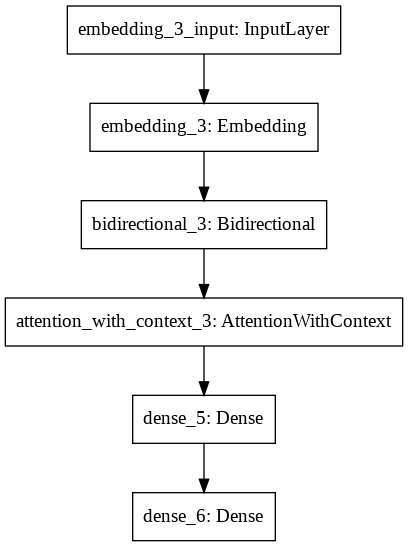

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

## Training using adam optimizer and binary cross entropy

In [0]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(padded_docs_train, y_train.values, 
                    validation_data=(padded_docs_val, y_val.values),
                    epochs=5, batch_size=256, 
                    verbose=2)

Train on 13244 samples, validate on 1472 samples
Epoch 1/5
 - 7s - loss: 0.1392 - accuracy: 0.9484 - val_loss: 0.3514 - val_accuracy: 0.8843
Epoch 2/5
 - 6s - loss: 0.1267 - accuracy: 0.9545 - val_loss: 0.3758 - val_accuracy: 0.8825
Epoch 3/5
 - 6s - loss: 0.1208 - accuracy: 0.9572 - val_loss: 0.3576 - val_accuracy: 0.8819
Epoch 4/5
 - 6s - loss: 0.1158 - accuracy: 0.9590 - val_loss: 0.3906 - val_accuracy: 0.8805
Epoch 5/5
 - 6s - loss: 0.1115 - accuracy: 0.9605 - val_loss: 0.4023 - val_accuracy: 0.8814


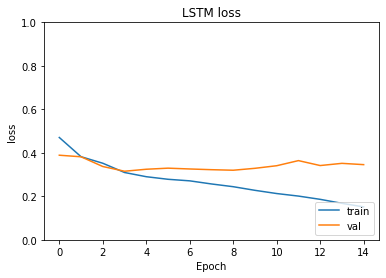

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [0]:
# Final evaluation of the model
scores = model.evaluate(padded_docs_test, y_test.values)

print("Accuracy: %.2f%%" % (scores[1]*100))

3680/3680 [==============================] - 3s 846us/step
Accuracy: 88.94%


# Save Model

In [0]:
model.save('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Model/modelbiLSTM_nostemstopword_att.h5')

# Predict and Result

## Predict Data Test

In [0]:
predict = model.predict(padded_docs_test)
predict_train = model.predict(padded_docs_train)
predict_val = model.predict(padded_docs_val)
thresholds=0.5

In [0]:
def labelSetAccuracy(y_true, y_pred):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
#         print('\nset_true: {0}'.format(set_true))
#         print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [0]:
pred_test = predict.copy()
pred_test[pred_test>=0.5] = 1
pred_test[pred_test<0.5] = 0
acc = accuracy_score(y_test.values,pred_test)
haml_loss = hamming_loss(y_test.values,pred_test)
label_acc = labelSetAccuracy(y_test.values,pred_test)
print("threshold = ",thresholds)
print("exact accuracy = ", acc)
print("hamming loss = ",haml_loss)
print("label based accuracy = ",label_acc)
print("==============================")

threshold =  0.5
exact accuracy =  0.5758152173913044
hamming loss =  0.11023550724637682
label based accuracy =  0.6872987836438923


In [0]:
pred_train = predict_train.copy()
pred_train[pred_train>=0.5] = 1
pred_train[pred_train<0.5] = 0
acc = accuracy_score(y_train.values,pred_train)
haml_loss = hamming_loss(y_train.values,pred_train)
label_acc = labelSetAccuracy(y_train.values,pred_train)
print("threshold = ",thresholds)
print("exact accuracy = ", acc)
print("hamming loss = ",haml_loss)
print("label based accuracy = ",label_acc)
print("==============================")


threshold =  0.5
exact accuracy =  0.7264421624886741
hamming loss =  0.04870759085875365
label based accuracy =  0.8589297399720989


In [0]:
pred_val = predict_val.copy()
pred_val[pred_val>=0.5] = 1
pred_val[pred_val<0.5] = 0
acc = accuracy_score(y_val.values,pred_val)
haml_loss = hamming_loss(y_val.values,pred_val)
label_acc = labelSetAccuracy(y_val.values,pred_val)
print("threshold = ",thresholds)
print("exact accuracy = ", acc)
print("hamming loss = ",haml_loss)
print("label based accuracy = ",label_acc)
print("==============================")

threshold =  0.5
exact accuracy =  0.5441576086956522
hamming loss =  0.11758378623188406
label based accuracy =  0.6705963703416149


## Analysis Result

### Data Validation Predict Result ANalysis

In [0]:
data_val = pd.DataFrame(data=X_val,columns=['Tweet_Parsed']).join(y_val).reset_index(drop=True)

In [0]:
data_val.head()

,Tweet_Parsed,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,so much berengsek people in the world,1,1,0,1,0,0,0,0,1,0,1,0
1,so how can i get my rekening berengsek rekenin...,0,1,0,0,0,0,0,0,0,0,0,0
2,rt user dasar bajingan url,0,1,0,0,0,0,0,0,0,0,0,0
3,user karena kecebong tidak akan mengakui pria ...,1,1,0,1,0,0,0,0,1,0,1,0
4,rt user tidak ada urusannya monyet aku broken ...,1,1,1,0,0,0,0,0,1,1,0,0


In [0]:
data_val_predict = pd.DataFrame(data=X_val,columns=['Tweet_Parsed']).reset_index(drop=True).join(pd.DataFrame(data=pred_val, columns=y_val.columns))

In [0]:
data_val_predict.head()

,Tweet_Parsed,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,so much berengsek people in the world,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,so how can i get my rekening berengsek rekenin...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,rt user dasar bajingan url,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,user karena kecebong tidak akan mengakui pria ...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,rt user tidak ada urusannya monyet aku broken ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Check Number of Labels on Predict Data

In [0]:
label_size0_val = []
label_size1_val = []

for i in data_val.columns[1:]:
    label_size0_val.append(len(data_val[data_val[i]==0]))
    label_size1_val.append(len(data_val[data_val[i]==1]))

label_size0_val_predict = []
label_size1_val_predict = []

for i in data_val_predict.columns[1:]:
    label_size0_val_predict.append(len(data_val_predict[data_val_predict[i]==0]))
    label_size1_val_predict.append(len(data_val_predict[data_val_predict[i]==1]))

In [0]:
dat_anls_val = pd.DataFrame({
    'label' : data_val.columns[1:],
    'stats' : ["negative" for i in range(len(data_val.columns[1:]))],
    'jumlah' : label_size0_val
}).append(
    pd.DataFrame({
        'label' : data_val.columns[1:],
        'stats' : ["positive" for i in range(len(data_val.columns[1:]))],
        'jumlah' : label_size1_val
    })
)

# dat_anls_val = dat_anls_val.set_index(['label'], drop=True)

dat_anls_val_predict = pd.DataFrame({
    'label' : data_val_predict.columns[1:],
    'stats' : ["negative" for i in range(len(data_val_predict.columns[1:]))],
    'jumlah' : label_size0_val_predict
}).append(
    pd.DataFrame({
        'label' : data_val_predict.columns[1:],
        'stats' : ["positive" for i in range(len(data_val_predict.columns[1:]))],
        'jumlah' : label_size1_val_predict
    })
)

# dat_anls_val_predict = dat_anls_val_predict.set_index(['label'], drop=True)

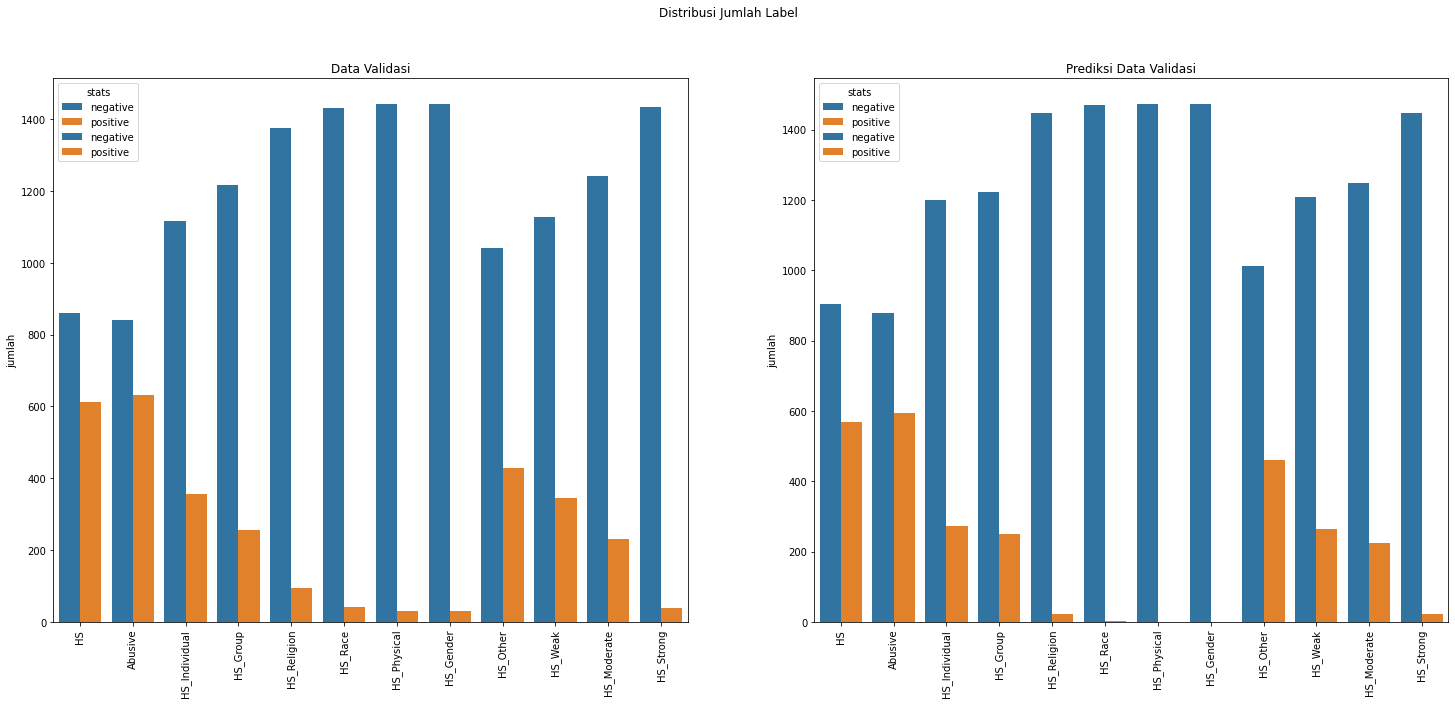

In [0]:
plt.figure(figsize=(25,10))
plt.suptitle('Distribusi Jumlah Label')

plt.subplot(1,2,1)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val).get_xticklabels(),rotation=90)
plt.title("Data Validasi")
plt.xlabel('')

plt.subplot(1,2,2)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val_predict).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val_predict).get_xticklabels(),rotation=90)
plt.title("Prediksi Data Validasi")
plt.xlabel('')

plt.show()

In [0]:
pd.DataFrame({
    "label" : data_val.columns[1:],
    "negative (true)" : dat_anls_val[dat_anls_val['stats'] == "negative"]["jumlah"].values,
    "positive (true)" : dat_anls_val[dat_anls_val['stats'] == "positive"]["jumlah"].values,
    "negative (predict)" : dat_anls_val_predict[dat_anls_val_predict['stats'] == "negative"]["jumlah"].values,
    "positive (predict)" : dat_anls_val_predict[dat_anls_val_predict['stats'] == "positive"]["jumlah"].values
})

,label,negative (true),positive (true),negative (predict),positive (predict)
0,HS,859,613,903,569
1,Abusive,840,632,879,593
2,HS_Individual,1115,357,1200,272
3,HS_Group,1216,256,1222,250
4,HS_Religion,1376,96,1448,24
5,HS_Race,1431,41,1469,3
6,HS_Physical,1441,31,1472,0
7,HS_Gender,1441,31,1472,0
8,HS_Other,1042,430,1011,461
9,HS_Weak,1128,344,1208,264


#### OOV Check

In [0]:
def generate_ngrams(s):
    
    # Break sentence in the token, remove empty tokens
    tokens = [token for token in s.str.split(" ") if token != ""]
    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = np.concatenate(tokens)
    return ngrams

def oov(fitur,token):
    outOfVocab = []
    for i in token:
        if i not in fitur:
            outOfVocab.append(i)
    return outOfVocab

def oov_count(oovList):
    oovCount = {}
    for i in oovList:
        if i in oovCount.keys():
            oovCount[i] = oovCount[i]+1
        else:
            oovCount[i] = 1
    return oovCount

In [0]:
join_data_val = data_val.join(data_val_predict.drop(['Tweet_Parsed'],axis=1),rsuffix="_predict")

In [0]:
miss_exact_tweet_val = join_data_val[(join_data_val["HS"]!=join_data_val["HS_predict"]) | (join_data_val["Abusive"] != join_data_val["Abusive_predict"]) | (join_data_val["HS_Individual"] != join_data_val["HS_Individual_predict"]) | (join_data_val["HS_Group"] != join_data_val["HS_Group_predict"]) | (join_data_val["HS_Religion"] != join_data_val["HS_Religion_predict"]) | (join_data_val["HS_Race"] != join_data_val["HS_Race"]) | (join_data_val["HS_Physical"] != join_data_val["HS_Physical_predict"]) | (join_data_val["HS_Gender"] != join_data_val["HS_Gender_predict"]) | (join_data_val["HS_Other"] != join_data_val["HS_Other_predict"]) | (join_data_val["HS_Weak_predict"] != join_data_val["HS_Weak_predict"]) | (join_data_val["HS_Moderate_predict"] != join_data_val["HS_Moderate_predict"]) | (join_data_val["HS_Strong_predict"] != join_data_val["HS_Strong_predict"])]

In [0]:
oov_val = oov(vect.index_word.values(), generate_ngrams(miss_exact_tweet_val['Tweet_Parsed']))
oov_val_count = oov_count(oov_val)

In [0]:
oov_val_count

{'': 877,
 'adele': 1,
 'admirer': 1,
 'advertise': 1,
 'afford': 1,
 'afterwards': 1,
 'ajari': 1,
 'akil': 1,
 'akses': 1,
 'aksinesia': 1,
 'alia': 1,
 'animo': 1,
 'apostate': 1,
 'arifinto': 1,
 'armed': 1,
 'arrogance': 1,
 'aus': 1,
 'baas': 1,
 'bablas': 1,
 'backing': 1,
 'backpass': 2,
 'baikin': 1,
 'bala': 1,
 'bangsaku': 1,
 'barakat': 1,
 'baterai': 1,
 'beheaded': 1,
 'belaganya': 1,
 'bengkok': 1,
 'beracun': 1,
 'berbohong': 1,
 'bergaya': 1,
 'bergelimang': 1,
 'bergengsi': 1,
 'bergibah': 1,
 'berhentinya': 1,
 'berlusconi': 1,
 'bermigrasi': 1,
 'berpeci': 1,
 'bertalenta': 1,
 'berteriaklah': 1,
 'besanpun': 1,
 'bimas': 1,
 'bish': 1,
 'blamed': 1,
 'brainer': 1,
 'budhis': 1,
 'buntel': 1,
 'bunuhlah': 1,
 'carbondioxide': 1,
 'carrier': 1,
 'cashflow': 1,
 'catcalling': 1,
 'cetar': 2,
 'chief': 1,
 'cingkrang': 1,
 'cit': 1,
 'civilization': 1,
 'coach': 1,
 'coexist': 1,
 'coins': 1,
 'colonels': 1,
 'colonised': 1,
 'colonisers': 1,
 'compromised': 1,
 'comun

In [0]:
print("number of OOV words : ", len(oov_val))
print("number of unique OOV words : ", len(oov_val_count))

number of OOV words :  1340
number of unique OOV words :  445


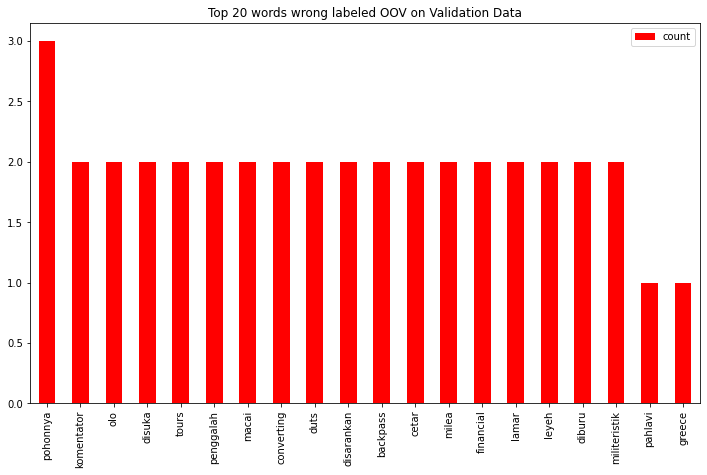

In [0]:
df_oov_val = pd.DataFrame(oov_val_count.items(),columns=["Tweet","count"])
df_oov_val.sort_values(['count'],ascending=False)[1:21].plot(
    kind='bar', y='count',x='Tweet', color='red', title='Top 20 words wrong labeled OOV on Validation Data', figsize=(12,7))
plt.xlabel("")
plt.show()

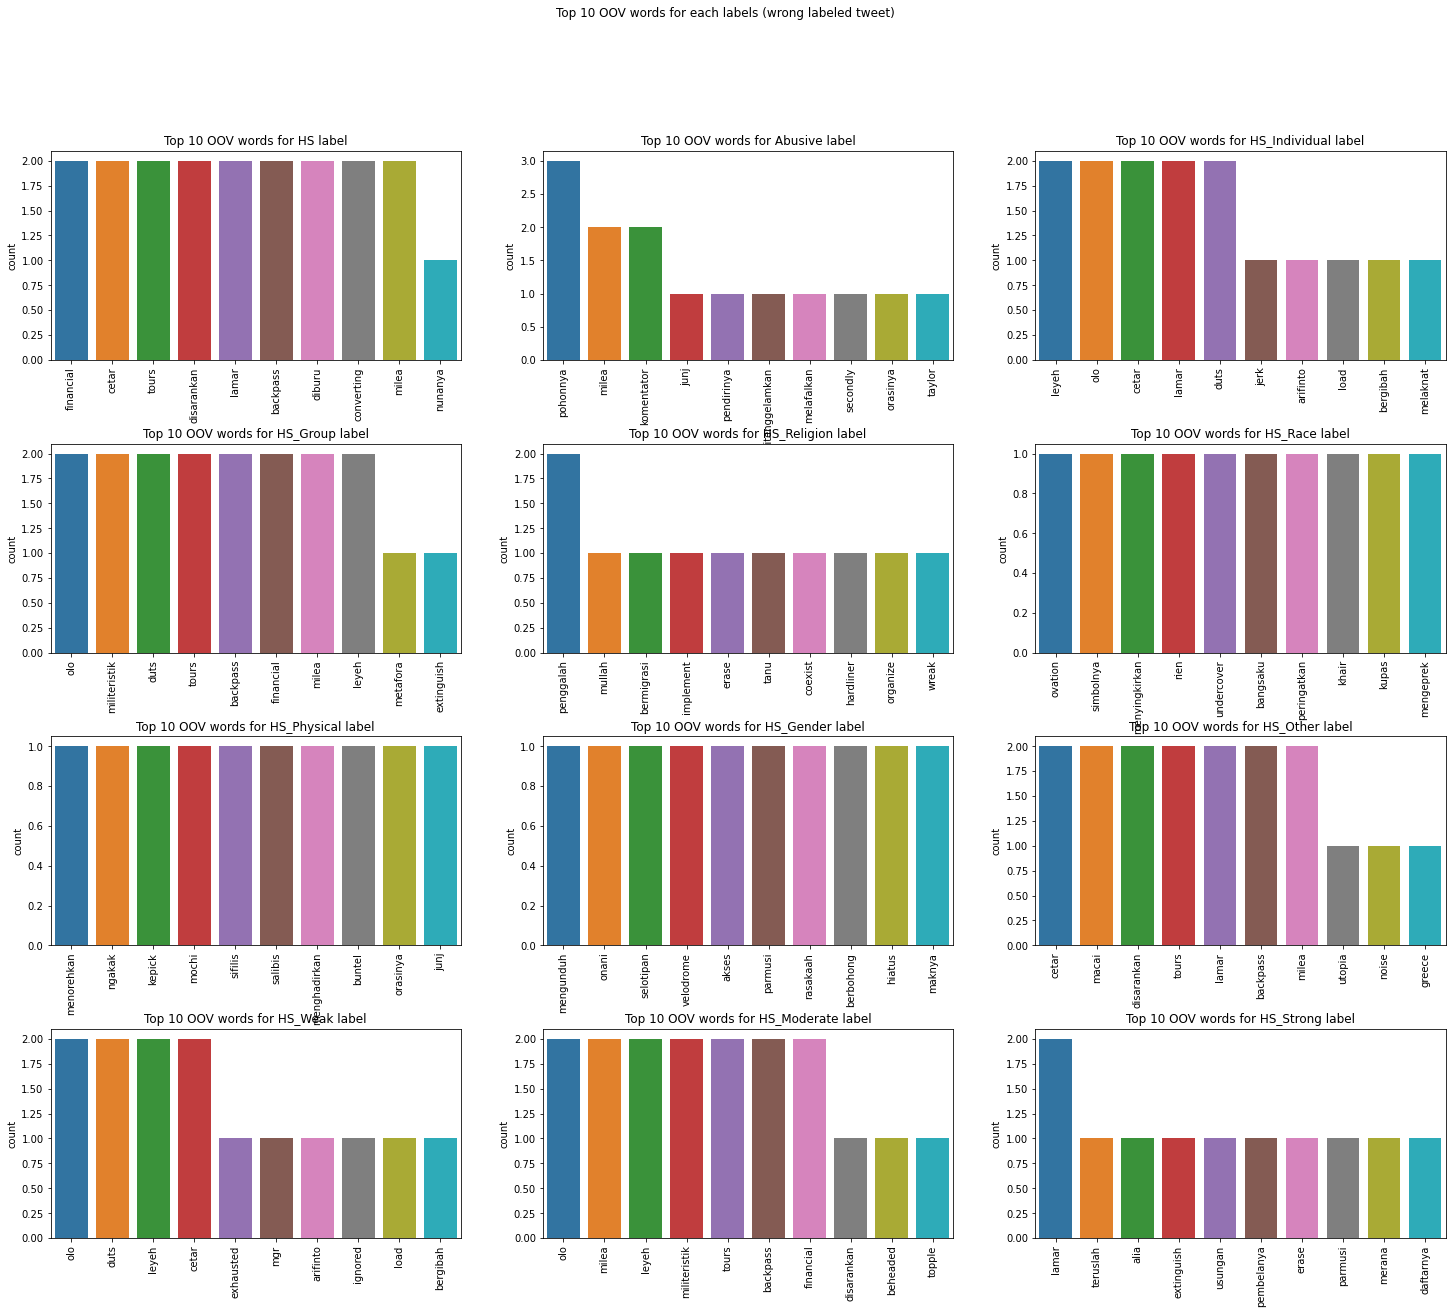

In [0]:
target = y_val.columns

plt.figure(figsize=(25,20))
plt.suptitle('Top 10 OOV words for each labels (wrong labeled tweet)')
for i in range (len(target)):
    plt.subplot(4,3,i+1)
    plt.subplots_adjust(hspace=0.4)
    wrongtweet = join_data_val[join_data_val[target[i]]!=join_data_val[target[i]+str("_predict")]]
    wrongtoken = generate_ngrams(wrongtweet['Tweet_Parsed']).tolist()
    wrong_oov = oov(vect.index_word.values(), wrongtoken)
    wrong_oov_count = oov_count(wrong_oov)
    frame = pd.DataFrame(wrong_oov_count.items(),columns=["Tweet","count"])
    frame = frame.sort_values(['count'],ascending=False)[1:11]
    sns.barplot(x="Tweet", y="count", data=frame).set_xticklabels(sns.barplot(x="Tweet", y="count", data=frame).get_xticklabels(),rotation=90)
    title='Top 10 OOV words for '+str(target[i])+" label"
    plt.title(title)
    plt.xlabel("")

#### Tweet Check

In [0]:
miss_exact_tweet_val['Tweet_Parsed'].values.tolist()

['so much berengsek people in the world',
 'rt user dasar bajingan url',
 'user karena kecebong tidak akan mengakui pria lajang  cuma lulusan  sastra sebagai profesor karena untuk disebut profesor anak sampai  tau harus melalui strata pendidikan lagi setelah  itu jawab an kenapa kecebong lebih cerdas dari bani kampret ',
 'rt user tidak ada urusannya monyet aku broken home tidak begitu begitu amat malah dipukuli sama teman teman aku  kaya raya tidak ada tidak ada h ',
 'user user aku lagi celeng tidak buat synna emosi jangan mancing  ',
 'bahas islam merusak nilai user penguatan karakter melalui revitalisasi pendidikan nilai',
 'user kamu kafir banci   ampun sudah kafir banci lagi jangan sedih  cong kamu google  kafir banci kayak kamu ',
 'sendu gila rasa ',
 'salah satu obyek vital  pengamanannya lemah itu gedung dewan perwakilan rakyat semoga dengan disahkannya undang undang anti terorisme  baru dewan perwakilan rakyat tidak jadi sasaran bom bunuh diri amin tapi doa saya biasanya tid

In [0]:
miss_exact_tweet_val.iloc[:,1:-12].columns

Index(['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race',
       'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate',
       'HS_Strong'],
      dtype='object')

In [0]:
miss_exact_tweet_val.iloc[:,1:-12].values.tolist()

[[1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
 [1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
 [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
 [1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
 [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
 [1, 0, 0, 1, 0, 0, 0, 0,

In [0]:
miss_exact_tweet_val.iloc[:,-12:].values.tolist()

[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0],
 [1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0

### Data Test Predict Result Analysis

In [0]:
data_test_predict = pd.DataFrame(data=data_test['Tweet'],columns=['Tweet']).reset_index(drop=True).join(pd.DataFrame(data=pred_test, columns=y_test.columns)).join(pd.DataFrame(data=data_test['Tweet_Parsed'],columns=['Tweet_Parsed']).reset_index(drop=True))

#### Check Number of Labels on Predict Data

In [0]:
label_size0_test = []
label_size1_test = []

for i in data_test.columns[1:-1]:
    label_size0_test.append(len(data_test[data_test[i]==0]))
    label_size1_test.append(len(data_test[data_test[i]==1]))

label_size0_test_predict = []
label_size1_test_predict = []

for i in data_test_predict.columns[1:-1]:
    label_size0_test_predict.append(len(data_test_predict[data_test_predict[i]==0]))
    label_size1_test_predict.append(len(data_test_predict[data_test_predict[i]==1]))

In [0]:
dat_anls_test = pd.DataFrame({
    'label' : data_test.columns[1:-1],
    'stats' : ["negative" for i in range(len(data_test.columns[1:-1]))],
    'jumlah' : label_size0_test
}).append(
    pd.DataFrame({
        'label' : data_test.columns[1:-1],
        'stats' : ["positive" for i in range(len(data_test.columns[1:-1]))],
        'jumlah' : label_size1_test
    })
)

# dat_anls_test = dat_anls_test.set_index(['label'], drop=True)

dat_anls_test_predict = pd.DataFrame({
    'label' : data_test_predict.columns[1:-1],
    'stats' : ["negative" for i in range(len(data_test_predict.columns[1:-1]))],
    'jumlah' : label_size0_test_predict
}).append(
    pd.DataFrame({
        'label' : data_test_predict.columns[1:-1],
        'stats' : ["positive" for i in range(len(data_test_predict.columns[1:-1]))],
        'jumlah' : label_size1_test_predict
    })
)

# dat_anls_test_predict = dat_anls_test_predict.set_index(['label'], drop=True)

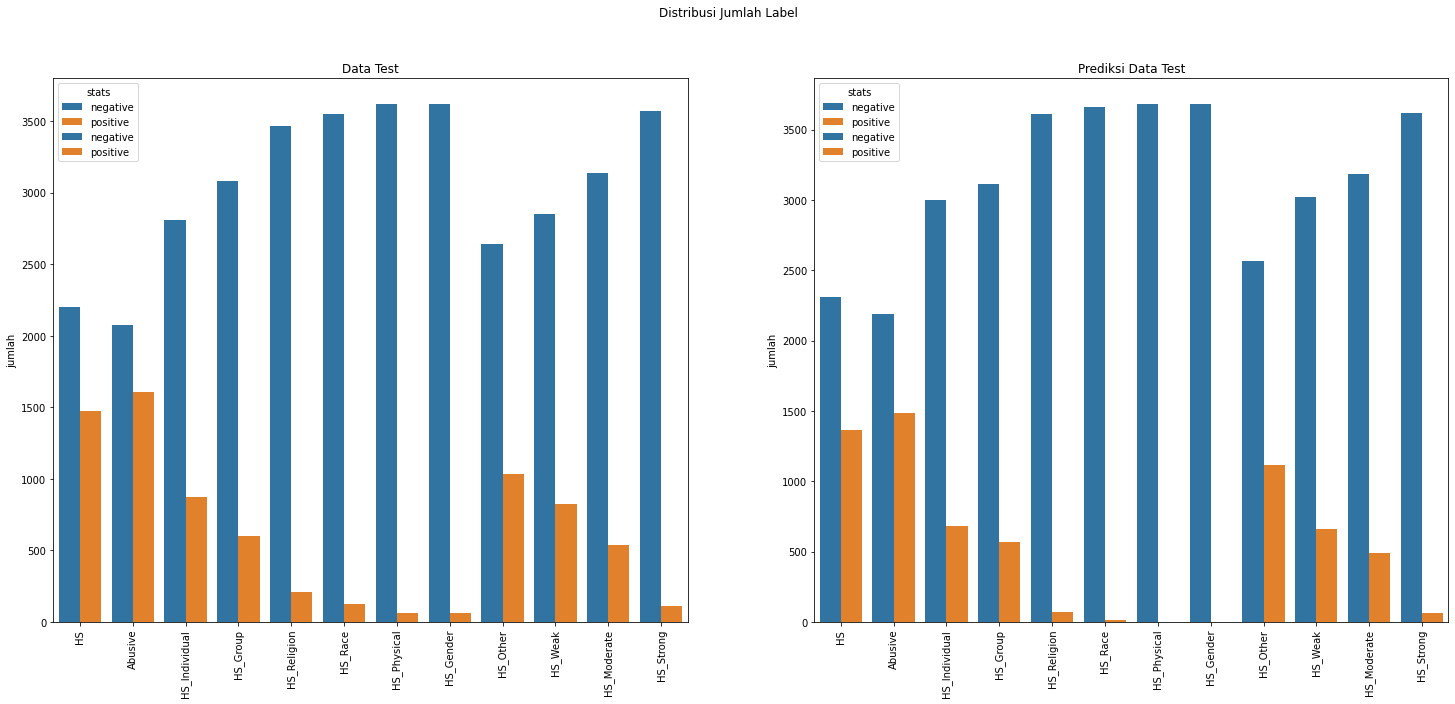

In [0]:
plt.figure(figsize=(25,10))
plt.suptitle('Distribusi Jumlah Label')

plt.subplot(1,2,1)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test).get_xticklabels(),rotation=90)
plt.title("Data Test")
plt.xlabel('')

plt.subplot(1,2,2)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test_predict).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test_predict).get_xticklabels(),rotation=90)
plt.title("Prediksi Data Test")
plt.xlabel('')

plt.show()

In [0]:
pd.DataFrame({
    "label" : data_test.columns[1:-1],
    "negative (true)" : dat_anls_test[dat_anls_test['stats'] == "negative"]["jumlah"].values,
    "positive (true)" : dat_anls_test[dat_anls_test['stats'] == "positive"]["jumlah"].values,
    "negative (predict)" : dat_anls_test_predict[dat_anls_test_predict['stats'] == "negative"]["jumlah"].values,
    "positive (predict)" : dat_anls_test_predict[dat_anls_test_predict['stats'] == "positive"]["jumlah"].values
})

,label,negative (true),positive (true),negative (predict),positive (predict)
0,HS,2204,1476,2314,1366
1,Abusive,2075,1605,2192,1488
2,HS_Individual,2806,874,2998,682
3,HS_Group,3078,602,3114,566
4,HS_Religion,3467,213,3612,68
5,HS_Race,3551,129,3664,16
6,HS_Physical,3617,63,3680,0
7,HS_Gender,3616,64,3680,0
8,HS_Other,2643,1037,2565,1115
9,HS_Weak,2854,826,3021,659


#### OOV Check

In [0]:
join_data_test = data_test.join(data_test_predict.drop(['Tweet','Tweet_Parsed'],axis=1),rsuffix="_predict")

In [0]:
miss_exact_tweet_test = join_data_test[(join_data_test["HS"]!=join_data_test["HS_predict"]) | (join_data_test["Abusive"] != join_data_test["Abusive_predict"]) | (join_data_test["HS_Individual"] != join_data_test["HS_Individual_predict"]) | (join_data_test["HS_Group"] != join_data_test["HS_Group_predict"]) | (join_data_test["HS_Religion"] != join_data_test["HS_Religion_predict"]) | (join_data_test["HS_Race"] != join_data_test["HS_Race"]) | (join_data_test["HS_Physical"] != join_data_test["HS_Physical_predict"]) | (join_data_test["HS_Gender"] != join_data_test["HS_Gender_predict"]) | (join_data_test["HS_Other"] != join_data_test["HS_Other_predict"]) | (join_data_test["HS_Weak_predict"] != join_data_test["HS_Weak_predict"]) | (join_data_test["HS_Moderate_predict"] != join_data_test["HS_Moderate_predict"]) | (join_data_test["HS_Strong_predict"] != join_data_test["HS_Strong_predict"])]

In [0]:
oov_test = oov(vect.index_word.values(), generate_ngrams(miss_exact_tweet_test['Tweet_Parsed']))
oov_test_count = oov_count(oov_test)

In [0]:
oov_test_count

{'': 2085,
 'cingkrang': 3,
 'memberlakukan': 1,
 'perjudian': 1,
 'hibahan': 1,
 'penawaran': 1,
 'diploma': 1,
 'lepasan': 1,
 'dpli': 1,
 'ismppi': 1,
 'kemasukan': 1,
 'unisza': 1,
 'sukacita': 1,
 'dimaklumkan': 1,
 'zainal': 1,
 'dominated': 2,
 'indus': 1,
 'tunku': 1,
 'ngechat': 1,
 'jandro': 1,
 'tangung': 1,
 'setoran': 1,
 'raid': 1,
 'giratina': 1,
 'menggila': 1,
 'presidenpun': 1,
 'jongin': 1,
 'jempolnya': 1,
 'vin': 1,
 'pocky': 1,
 'sekop': 1,
 'karbitan': 2,
 'siak': 1,
 'gelapi': 1,
 'kabah': 1,
 'banners': 1,
 'polah': 1,
 'dimiskinkan': 1,
 'escalate': 1,
 'menyetop': 1,
 'persi': 1,
 'raganya': 1,
 'notulensi': 1,
 'kebayoran': 1,
 'omelan': 1,
 'mengunyah': 1,
 'semrawut': 1,
 'mengambang': 1,
 'critisized': 2,
 'penangite': 1,
 'sheeple': 1,
 'dapig': 1,
 'disregard': 1,
 'qotd': 1,
 'tangisan': 1,
 'digentayangi': 1,
 'kegelisahannya': 1,
 'ngawang': 1,
 'disogok': 1,
 'bum': 1,
 'relakan': 1,
 'gubrak': 1,
 'formatnya': 1,
 'ringsek': 1,
 'boil': 1,
 'whacka

In [0]:
print("number of OOV words : ", len(oov_test))
print("number of unique OOV words : ", len(oov_test_count))

number of OOV words :  3392
number of unique OOV words :  1215


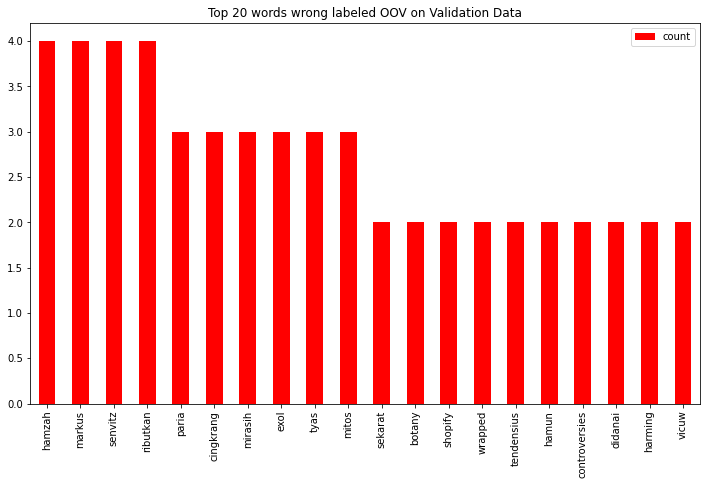

In [0]:
df_oov_test = pd.DataFrame(oov_test_count.items(),columns=["Tweet","count"])
df_oov_test.sort_values(['count'],ascending=False)[1:21].plot(
    kind='bar', y='count',x='Tweet', color='red', title='Top 20 words wrong labeled OOV on Validation Data', figsize=(12,7))
plt.xlabel("")
plt.show()

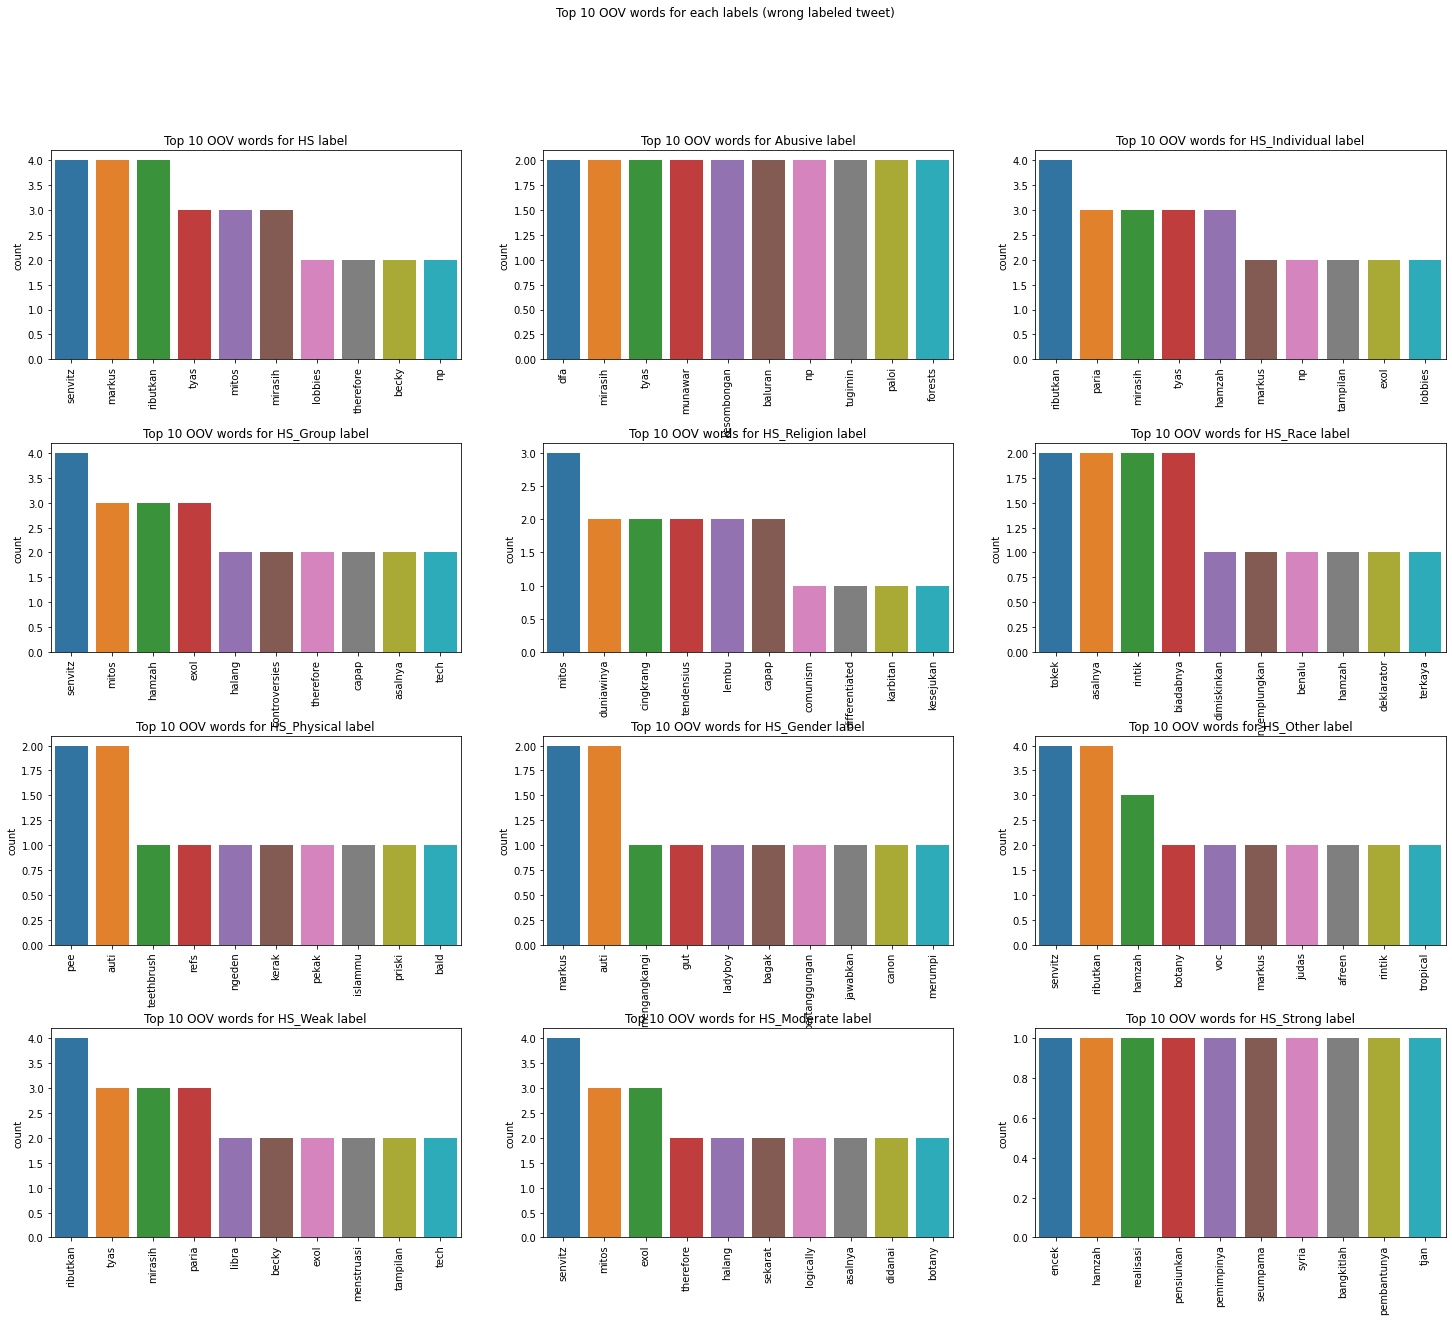

In [0]:
target = y_test.columns

plt.figure(figsize=(25,20))
plt.suptitle('Top 10 OOV words for each labels (wrong labeled tweet)')
for i in range (len(target)):
    plt.subplot(4,3,i+1)
    plt.subplots_adjust(hspace=0.4)
    wrongtweet = join_data_test[join_data_test[target[i]]!=join_data_test[target[i]+str("_predict")]]
    wrongtoken = generate_ngrams(wrongtweet['Tweet_Parsed']).tolist()
    wrong_oov = oov(vect.index_word.values(), wrongtoken)
    wrong_oov_count = oov_count(wrong_oov)
    frame = pd.DataFrame(wrong_oov_count.items(),columns=["Tweet","count"])
    frame = frame.sort_values(['count'],ascending=False)[1:11]
    sns.barplot(x="Tweet", y="count", data=frame).set_xticklabels(sns.barplot(x="Tweet", y="count", data=frame).get_xticklabels(),rotation=90)
    title='Top 10 OOV words for '+str(target[i])+" label"
    plt.title(title)
    plt.xlabel("")

#### Tweet Check

In [0]:
miss_exact_tweet_test['Tweet'].values.tolist()

["GANTENG TAPI BERENGSEK!!! BUAT APA?!!\nWHO DO YOU THINK YOU ARE? YOU'RE NOTHING!! TO ME! << REMEMBER THIS!!",
 'Does insulting one for being "Cina", "Kafir", make you a better Muslim?',
 "USER Khan yg ngajarin si garong kafir'",
 "USER Anak pecun... ga jauh2 dr hobi zina.. haha'",
 'USER Udah siap di demo berjilid2 sama bani cingkrang ? Malaysia memberlakukan syariat Islam, tapi melegalkan perjudian dengan berbagai syarat dan ketentuan yg "strict".\'',
 "USER Jancuk! Pingin gue tabok itu anak'",
 'HEBAHAN PENAWARAN PROGRAM DIPLOMA PENDIDIKAN LEPASAN IJAZAH (DPLI) DAN PROGRAM IJAZAH SARJANA MUDA PENDIDIKAN (PENDIDIKAN ISLAM) (ISMPPI) KEMASUKAN SEPTEMBER 2018 DI UNISZA.; ; Sukacita dimaklumkan bahawa Universiti Sultan Zainal...',
 'I like you. You like him, itukan berengsek :3 #nyampah',
 '#MataNajwaDebatJakarta lucu banget jawaban ahok.. gak nyambung. Ditanya apa di jawab apa. Kena skak mat d pertanyaan isu agama tdi. Dasar cina tolol hahaha',
 'Over 190 million Indonesians have voted

In [0]:
miss_exact_tweet_test['Tweet_Parsed'].values.tolist()

['ganteng tapi berengsek buat apa who do you think you are you re nothing to me remember this ',
 'does insulting one for being cina kafir make you a better muslim ',
 'user   mengajarkan  garong kafir ',
 'user anak pecun tidak jauh jauh dari hobi zina  ',
 'user sudah siap di demo berjilid jilid sama bani cingkrang malaysia memberlakukan syariat islam tapi melegalkan perjudian dengan berbagai syarat dan ketentuan  strict ',
 'user jancuk ingin aku tabok itu anak ',
 'hibahan penawaran program diploma pendidikan lepasan ijazah dpli dan program ijazah sarjana muda pendidikan pendidikan islam ismppi kemasukan september di unisza sukacita dimaklumkan bahwa universitas sultan zainal ',
 'i like you you like him itu  berengsek menyampah',
 ' mata najwa debat jakarta lucu banget jawaban ahok tidak menyambung ditanya apa di jawab apa kena sekak mat di pertanyaan isu agama tadi dasar cina tolol ',
 'over million indonesians have voted for a new presiden and parliament incumbent presiden joko 

In [0]:
miss_exact_tweet_test.iloc[:,1:-13].columns

Index(['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race',
       'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate',
       'HS_Strong'],
      dtype='object')

In [0]:
# real label
miss_exact_tweet_test.iloc[:,1:-13].values.tolist()

[[1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
 [1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0],
 [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0,

In [0]:
miss_exact_tweet_test.iloc[:,-12:].values.tolist()

[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [0]:
miss_exact_tweet_test.to_csv("/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/bestresult_bilstm_nostemstop.csv",index=False,sep=";")